# Seasonality

Loading data from matlab struct, reformatted in matlab from matlab table and then looking at the seasonality of the WIM data at Ceneri. Initially the years 2014-2016 were looked at and then due to gaps in data only 2014 was used to look at daily/hourly seasonality.

In [1]:
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

C:\Users\Isabelle\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Had to remove 'HH' column, has length of only one in the 

In [2]:
def load_table_from_struct(table_structure) -> pd.DataFrame():

    # get prepared data structure
    data = table_structure[0, 0]['table']['data']
    # get prepared column names
    data_cols = [name[0] for name in table_structure[0, 0]['columns'][0]]

    # create dict out of original table
    table_dict = {}
    for colidx in range(len(data_cols)):
        if data_cols[colidx] != 'HH':
            table_dict[data_cols[colidx]] = [val[0] for val in data[0, 0][0, colidx]]
    
    return pd.DataFrame(table_dict)

In [3]:
#Loading matrices from struct in matlab

dfs = []

for year in range(2014, 2017):
    struct = scipy.io.loadmat('CeneriData/Ceneri_%d_struct.mat' % year)
    dfs.append(load_table_from_struct(struct['Ceneri_struct']))
    
df = pd.concat(dfs, ignore_index=True)

In [4]:
df.shape

(4582618, 35)

In [5]:
df['T'].unique()

array([0], dtype=int64)

The 

In [6]:
df = df[['JJJJMMTT', 'ZST', 'FS', 'HHMMSS', 'CS', 'T']]
df['HHMMSS'] = df['HHMMSS'].astype(str) 

In [7]:
df['HH'] = df['HHMMSS'].str[:-4]

In [8]:
df['MMSS'] = df['HHMMSS'].str[-4:]

In [9]:
df['MM'] = df['MMSS'].str[:-2]

In [10]:
df.head()

,JJJJMMTT,ZST,FS,HHMMSS,CS,T,HH,MMSS,MM
0,20140101,408,4,2112,8,0,,2112,21
1,20140101,408,3,5554,3,0,,5554,55
2,20140101,408,3,10333,3,0,1,0333,03
3,20140101,408,4,14034,10,0,1,4034,40
4,20140101,408,4,15724,1,0,1,5724,57


In [11]:
df = df.replace(r'', np.nan, regex=True)

In [12]:
df = df.fillna(0)
df['HH'] = df['HH'].astype(int)
df['MM'] = df['MM'].astype(int)

In [13]:
df.head()

,JJJJMMTT,ZST,FS,HHMMSS,CS,T,HH,MMSS,MM
0,20140101,408,4,2112,8,0,0,2112,21
1,20140101,408,3,5554,3,0,0,5554,55
2,20140101,408,3,10333,3,0,1,0333,3
3,20140101,408,4,14034,10,0,1,4034,40
4,20140101,408,4,15724,1,0,1,5724,57


Now that the hour and minute are seperated it can be used to count the total occurances of trucks per hour/day to determine if there is seasonality in the daily signal.

In [14]:
df['Date'] = df['JJJJMMTT'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [15]:
df = df.drop(columns=['JJJJMMTT'])

In [16]:
df.head()

,ZST,FS,HHMMSS,CS,T,HH,MMSS,MM,Date
0,408,4,2112,8,0,0,2112,21,2014-01-01
1,408,3,5554,3,0,0,5554,55,2014-01-01
2,408,3,10333,3,0,1,0333,3,2014-01-01
3,408,4,14034,10,0,1,4034,40,2014-01-01
4,408,4,15724,1,0,1,5724,57,2014-01-01


In [17]:
df.to_csv('CeneriData/2014_2016_datetime.csv')

In [18]:
df_day = df.groupby('Date', as_index=True).MM.agg('sum')

In [19]:
df_day.head()

Date
2014-01-01    11537
2014-01-02    58053
2014-01-03    73842
2014-01-04    48463
2014-01-05    17793
Name: MM, dtype: int32

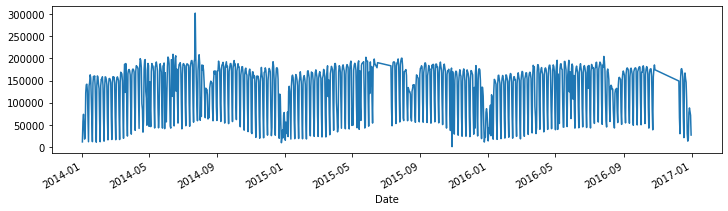

In [20]:
df_day.plot(figsize=(12,3))

Given the large gaps in data in 2015 and 2017, while there seems to be seasonal behavior on the yearly level, let's look specifically at 2014.

In [21]:
df_2014 = df_day.loc['2014-01-01':'2014-12-31']

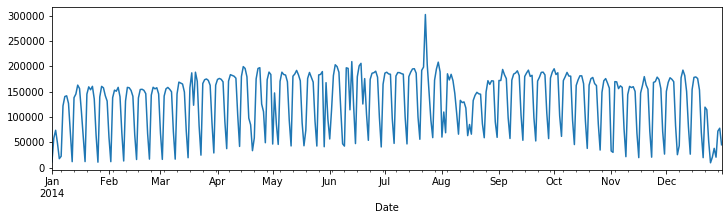

In [22]:
df_2014.plot(figsize=(12,3))

Below shows the weekly seasonality.

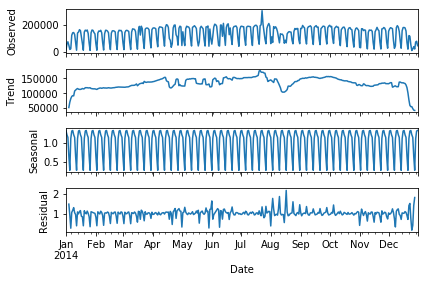

In [23]:
result = seasonal_decompose(df_2014, model='multiplicative')
result.plot()
pyplot.show()

Now we want to look at seasonality when the hour is incorporated.

In [24]:
df.head()

,ZST,FS,HHMMSS,CS,T,HH,MMSS,MM,Date
0,408,4,2112,8,0,0,2112,21,2014-01-01
1,408,3,5554,3,0,0,5554,55,2014-01-01
2,408,3,10333,3,0,1,0333,3,2014-01-01
3,408,4,14034,10,0,1,4034,40,2014-01-01
4,408,4,15724,1,0,1,5724,57,2014-01-01


In [25]:
df['Date'] += pd.to_timedelta(df.HH, unit='h')

In [26]:
df_day_hour = df.groupby('Date', as_index=True).MM.agg('sum')

In [27]:
df_2014_hour = df_day_hour.loc['2014-01-01 00:00:00':'2014-12-31 23:00:00']

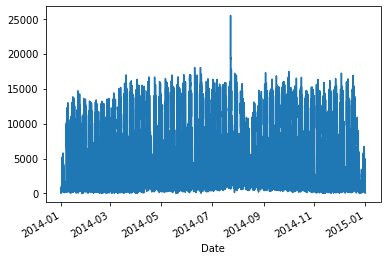

In [28]:
df_2014_hour.plot()

Below shows the 2014 seasonality by day. First it is necessary to remove any holidays or sundays. Sundays can easily be removed with the datetime and the holidays are taking from a list of Ticino holidays.

In [30]:
holidays = ['2014-01-01', '2014-01-06', '2014-03-19', '2014-04-21', '2014-05-01', '2014-05-29', '2014-06-09', '2014-06-19', 
            '2014-06-29', '2014-08-01', '2014-08-15', '2014-11-01', '2014-12-07', '2014-12-25', '2014-12-26']

In [33]:
df_2014_hour.shape

(8755,)

In [35]:
df_2014_weekdays = df_2014_hour.loc[~(df_2014_hour.index.floor('D').isin(holidays))]

In [37]:
df_2014_weekdays = df_2014_weekdays[df_2014_weekdays.index.weekday!=(5 or 6)]

In [38]:
df_2014_weekdays.shape

(7171,)

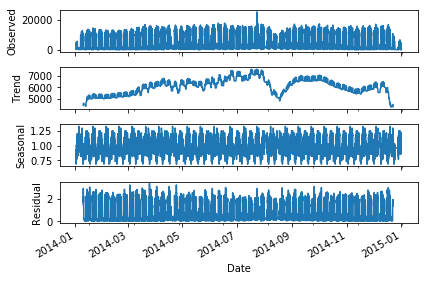

In [39]:
result = seasonal_decompose(df_2014_weekdays, model='multiplicative', freq=300)
result.plot()
pyplot.show()

Looking at a single month, March

In [40]:
df_2014_march_week = df_2014_weekdays.loc['2014-03-01 00:00:00':'2014-03-31 23:00:00']

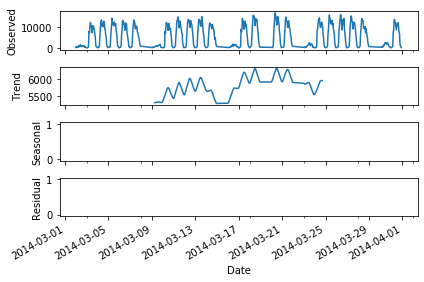

In [41]:
result = seasonal_decompose(df_2014_march, model='multiplicative', freq=300)
result.plot()
pyplot.show()

In [43]:
df_2014_week = df_2014_weekdays.loc['2014-03-24 00:00:00':'2014-03-28 23:00:00']

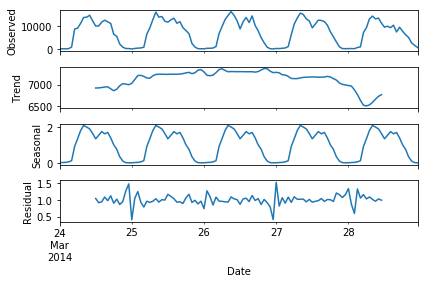

In [45]:
result = seasonal_decompose(df_2014_week, model='multiplicative')
result.plot()
pyplot.show()